<a href="https://colab.research.google.com/github/SvetlanaShkryleva/image-processing/blob/main/Practice_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ДЗ
1. Реализуйте высокочастотную фильтрацию на основе ядра Гаусса

2. Реализуйте удаление периодического шума

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

In [5]:
image = cv2.imread('periodic_noise.JPG')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

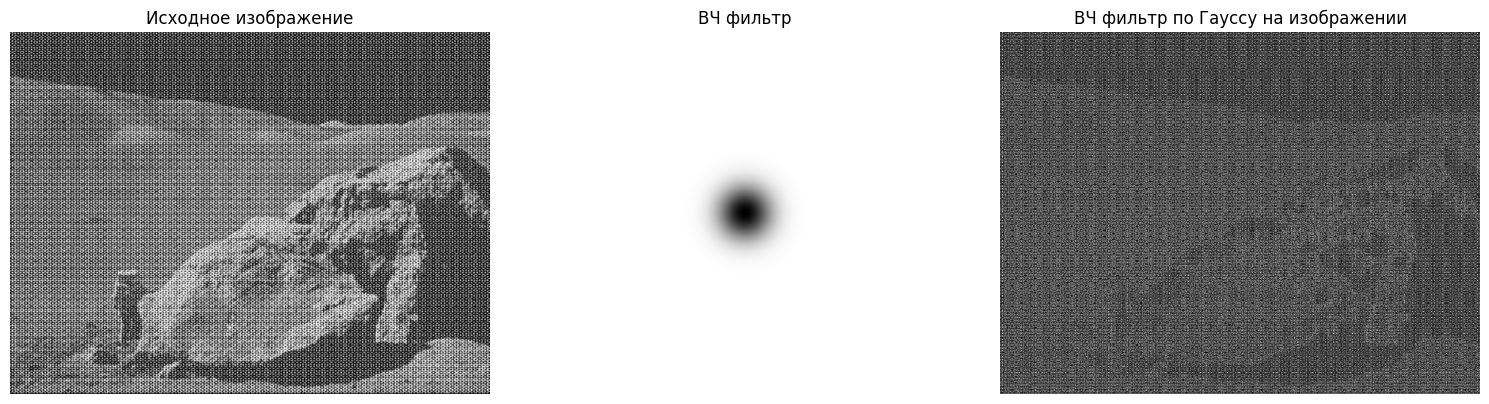

In [6]:
def gaussian_highpass_filter(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = image.shape
    x, y = np.ogrid[:rows, :cols]
    center_x, center_y = rows // 2, cols // 2

    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    sigma = 30
    gaussian_lowpass = np.exp(-(distance**2) / (2 * (sigma**2)))
    gaussian_highpass = 1 - gaussian_lowpass

    mask = np.zeros((rows, cols, 2), np.float32)
    mask[:,:,0] = gaussian_highpass
    mask[:,:,1] = gaussian_highpass

    dft_shift_filtered = dft_shift * mask
    f_ishift = np.fft.ifftshift(dft_shift_filtered)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back, gaussian_highpass

highpass_result, gaussian_mask = gaussian_highpass_filter(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(gaussian_mask, cmap='gray'); plt.title('ВЧ фильтр'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(highpass_result, cmap='gray'); plt.title('ВЧ фильтр по Гауссу на изображении'); plt.axis('off')
plt.tight_layout()
plt.show()

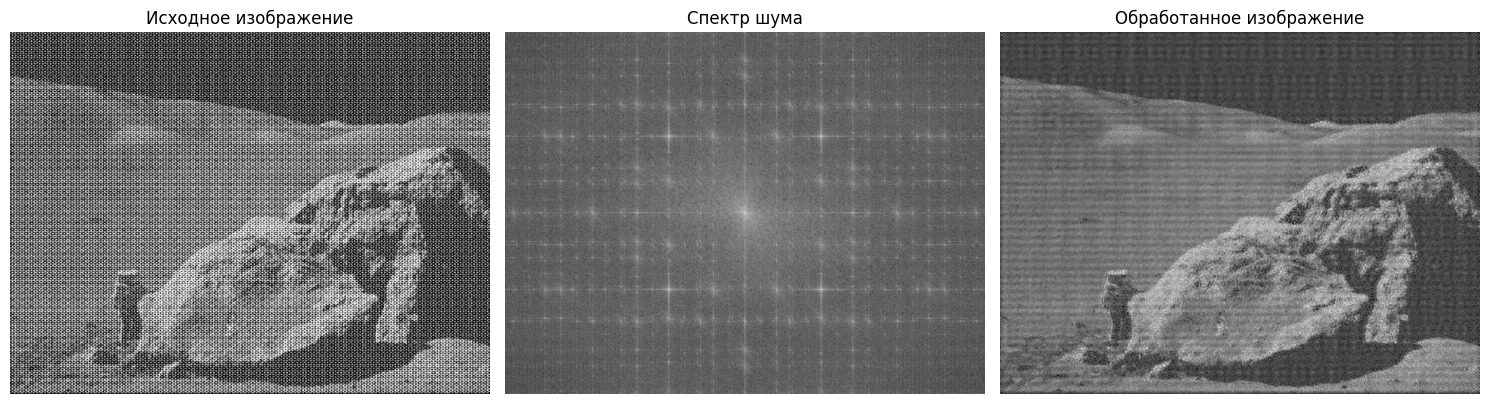

In [9]:
def remove_periodic_noise(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    threshold = np.percentile(magnitude, 96)
    noise_mask = magnitude > threshold

    rows, cols = image.shape
    center_y, center_x = rows // 2, cols // 2
    center_radius = min(rows, cols) // 10

    filter_mask = np.ones((rows, cols, 2), np.float32)

    for y in range(rows):
        for x in range(cols):
            if noise_mask[y, x]:
                dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist > center_radius:
                    filter_mask[y, x] = 0
                    filter_mask[rows-1-y, cols-1-x] = 0


    fshift = dft_shift * filter_mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

    denoised_image = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return denoised_image, magnitude

denoised_image, magnitude = remove_periodic_noise(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(magnitude, cmap='gray'); plt.title('Спектр шума'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(denoised_image, cmap='gray'); plt.title('Обработанное изображение'); plt.axis('off')
plt.tight_layout()
plt.show()